final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\tihen\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


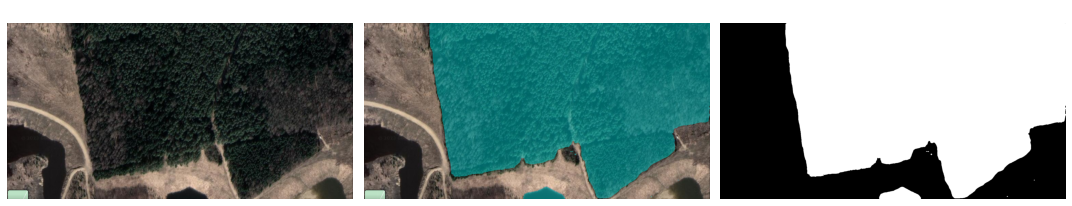

In [33]:
import functools
import warnings
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

import torch
from lang_sam import LangSAM

from torchvision.utils import draw_segmentation_masks

image = "c:\\Users\\tihen\\Downloads\\download.png"
# image = "./image.jpg"
text_prompt = "tree"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def calculate_area():
    img = cv2.imread('forest_mask.png')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    total_area = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 0:
            total_area += cv2.contourArea(cnt)

    image_size = 50
    white_area = total_area * (1 / (thresh.shape[0] * thresh.shape[1])) * (image_size ** 2)
    
    return white_area

def display_image_with_masks(image, mask, masks):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image", color='white')
    axes[0].axis('off')
    
    image_array = np.asarray(image)
    tensor_image = torch.from_numpy(image_array).permute(2, 0, 1)
    image_with_mask = draw_segmentation_masks(tensor_image, masks=masks, colors=['cyan'] * len(masks), alpha=0.4)
    axes[1].imshow(image_with_mask.numpy().transpose(1, 2, 0))
    axes[1].set_title(f"Forest mask", color='white')
    axes[1].axis('off')
    
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title(f"Area: {calculate_area():.2f} m²", color='white')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt, box_threshold=0.25)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]
            mask = functools.reduce(lambda m0, m1: np.where(m1 == 0, m0, m1), masks_np)
            # save_mask(mask, "forest_mask.png")

            display_image_with_masks(image_pil, mask, masks)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()


In [9]:
import cv2

img = cv2.imread('image_mask_1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

total_area = 0
for cnt in contours:
    if cv2.contourArea(cnt) > 0:
        total_area += cv2.contourArea(cnt)

image_size = 20
white_area = total_area * (1 / (thresh.shape[0] * thresh.shape[1])) * (image_size ** 2)

print(f'The area of white in the image is {white_area:.2f} square meters.')

The area of white in the image is 161.11 square meters.
